# Market Basket: case description

The manager of a grocery store asked for your help regarding the shelf layout of the shop. Until recently they
had about 200 SKUs (stock keeping units: unique item numbers), but the headquarter of the grocery chain
advised them to keep only 105 of them and introduce 64 new SKUs. The store manager is in charge of
where to place those items. You find the layout of the shop on the next page. The 105 existing items were
distributed evenly across the 7 shelves. In general everything can be changed, but the store manager
suggests to keep those 105 items at their current position, unless there are very strong reasons for an
alternative. Otherwise the customers could be even more confused than they will be anyway due to the
change.



You have been given sales data from a different shop that made the transition last year. The layout of this
shop is somewhat different, but you can get from the data, which items were purchased together and which
not.


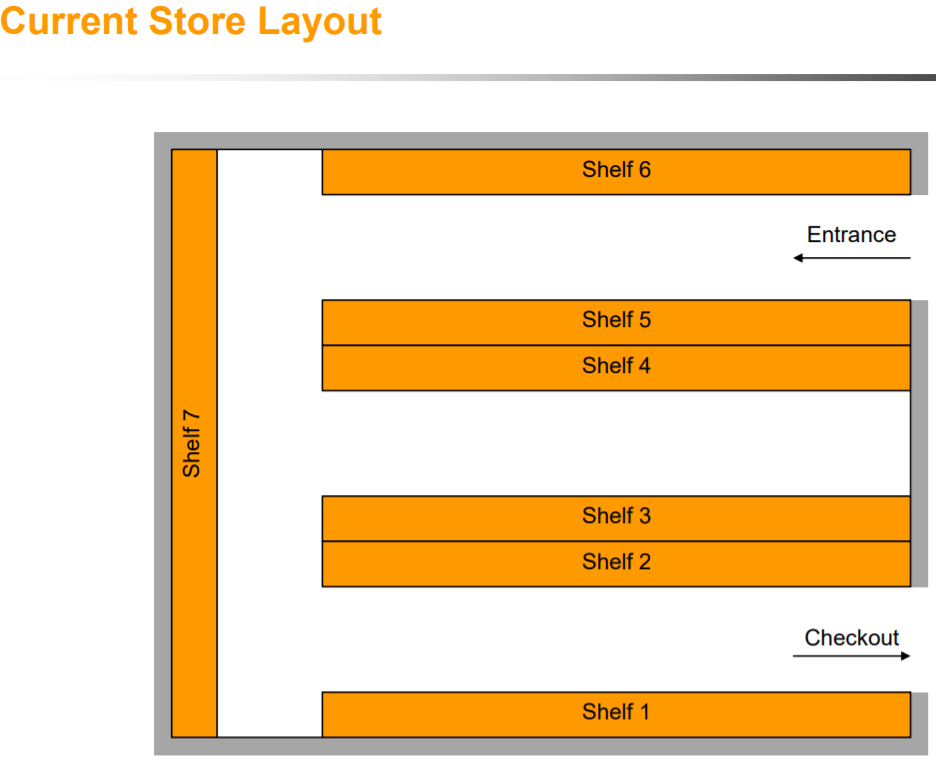![image.png]()

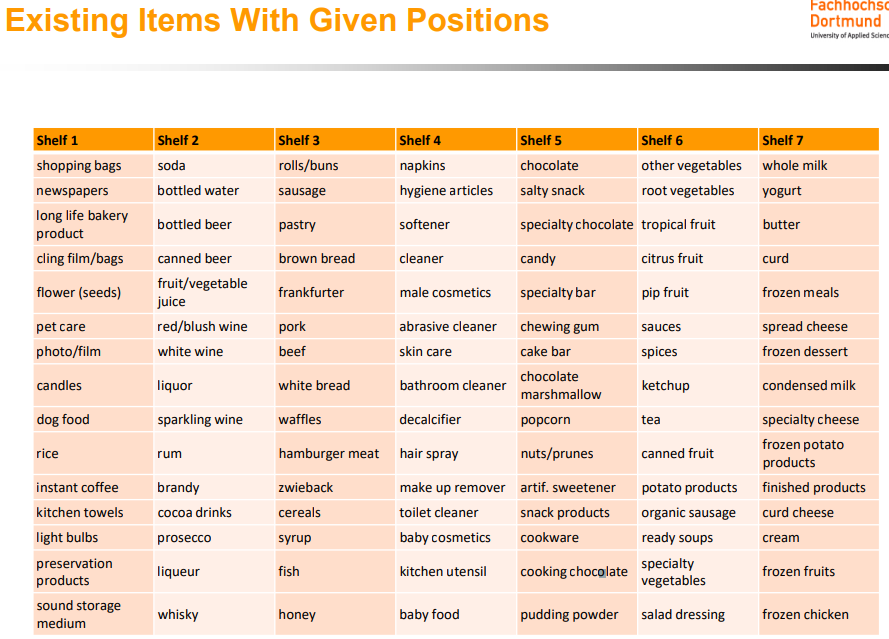

# Packages

In [1]:
import io
import requests
import pandas as pd
import numpy as np
import seaborn as sns
from collections import OrderedDict, Counter
from plotnine import *
import itertools

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator # to create a Word Cloud
from PIL import Image # Pillow with WordCloud to image manipulation

import matplotlib.pyplot as plt
%matplotlib inline

  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  # Utils

In [2]:
def load_dataset(url, sep=',', decode='utf-8', dtype=None, header=None):
    """Requesting url dataset
    
    Args:
        url: with the dataset
        sep: select the dataset separator
    
    Returns:
        a requested and decoded url
    """

    def requests_csv(url, decode='utf-8'):
        return (requests.get(url).content.decode(decode))
    
    return pd.read_csv(io.StringIO(requests_csv(url, decode)), sep=sep, dtype=dtype, header=header)

In [3]:
def create_association_dataset(data_support, verbose=None, fill_value=0):
    """A function that return lift or leverage dataset based on association rules. 
    
    Args:
        data_support: support dataframe = `data_freq / N`.
        verbose: 0 or 1. Verbosity mode. 0 = lift, 1 = leverage.
        fill_value: fill empty values.

    Returns:
        a dataframe based in the association rules (lift or leverage)
    """

    data_func = data_support.copy()
    for i in data_support.keys():
        for j in data_support.keys():
            if i == j:
                data_func.loc[i,j] = fill_value
            else:
                if verbose == 0: # lift
                    data_func.loc[i,j] = (data_support.loc[i,j]) / (data_support.loc[i,i]*data_support.loc[j,j])
                elif verbose == 1: # leverage
                    data_func.loc[i,j] = data_support.loc[i,j] - (data_support.loc[i,i] * data_support.loc[j,j])
    return data_func

In [4]:
def shelf_func(item):
    if item in placed_items:
        if item in shelf1:
            shelf = "shelf 1"
        elif item in shelf2:
            shelf = "shelf 2"
        elif item in shelf3:
            shelf = "shelf 3"
        elif item in shelf4:
            shelf = "shelf 4"
        elif item in shelf5:
            shelf = "shelf 5"
        elif item in shelf6:
            shelf = "shelf 6"
        elif item in shelf7:
            shelf = "shelf 7"
    elif item in unplaced_items:
        shelf = "no shelf"
    elif item == None:
        return None
    return shelf

In [5]:
def convert_rules_scales(df: pd.core.frame.DataFrame, rule_min: int, rule_max: int, subset: str, digits_line=3):
    """Convert any scale to the support scale, which is between the range 0 and 1.

    Args:
        df      : dataframe with the association rule subset that we want to change
        rule_min: minumun value from the association rule
        rule_max: maximum value from the association rule
        subset  : column which contain the elements from the association rule
        digits  : digits to round the function of the line (`func_rec`)
    
    Returns:
        A dataframe with the scale being converted to the selected scale
    """
    sup_values = {'min': 0, 'max': 1}

    def func_rec(m, x, b):
        if x != 0:
            return round(m * x + b, digits_line)
        else:
            return 0.0

    def func_pend(x1, x2, y1, y2):
        return (y2 - y1) / (x2 - x1)

    def func_b(x, y, m):
        return y - m * x
    
    rule_pend  = func_pend(x1=rule_min, y1=sup_values['min'], x2=rule_max, y2=sup_values['max']) 

    # i.e. association rules: subset = "leverage" or "lift"
    df[subset] = df[subset].apply(lambda i: func_rec(m=rule_pend, b=func_b(x=rule_max, y=sup_values['max'], m=rule_pend), x=i))

    return df

In [6]:
def simple_plot(X, y, title: str, X_label: str, y_label: str, figsize=(10, 8),
                linestyle='solid', color='red', legend_loc='upper left',
                size=10, rotation='vertical', b_grid=True, kind='line'):
    """A simple plotting function

    Args:
        X, y: datatype: array-like or scalar. The horizontal / vertical coordinates of the data points 
        title: title of the plot
        X_label, y_label: labels from the horizontal / vertical coordinates of the data points.
        kind: line or bar style
        args**

    Returns:
        A line or bar plot `plt.show()`.
    """

    plt.figure(figsize=figsize)
    if kind == 'line':
        plt.plot(X, y, linestyle=linestyle, color=color)
    elif kind == 'bar':
        plt.bar(X, y, linestyle=linestyle, color=color)

    plt.title(title)
    plt.xlabel(X_label)
    plt.ylabel(y_label)
    if kind == 'line':
        plt.legend(loc=legend_loc)
    plt.xticks(size=size, rotation=rotation)
    plt.yticks(size=size)
    plt.grid(b=b_grid)
    plt.axhline(y = y.mean(), color='orange', linestyle='--')
    
    plt.show()

In [7]:
def get_dfplot(kind, target_subset: str, sort_by: str, item_status=None, ascending=False, final=False):
    """Get a dataframe ready to plot between median or the mean value of the assigned `sort_by` option.

    Args:
        kind: `None`, median or mean type.
        target_subset: target column (Shelf or Item_1) 
        sort_by: i.e. support, leverage.
        item_status: `None`, placed or unplaced.
        ascending: `True` or `False`.
        final: `True` or `False`. If true you will use `one_item_data_final` insead `one_item_data`.

    Returns:
        Dataframe ready to plot; pandas series datatype.
    """
    global one_item_data
    global one_item_data_final

    if final == False:
        df_one_item = one_item_data
        
        if kind == 'median':
            df_plot = df_one_item[df_one_item["Type_Item_1"] == item_status].groupby("Shelf_Item_1").median().sort_values(sort_by, ascending=ascending)
        elif kind == 'mean':
            df_plot = df_one_item[df_one_item["Type_Item_1"] == item_status].groupby("Shelf_Item_1").mean().sort_values(sort_by, ascending=ascending)
        elif kind == None:
            df_plot = df_one_item[df_one_item["Type_Item_1"] == item_status].sort_values(sort_by, ascending=ascending)

    elif final == True:
        df_one_item = one_item_data_final
        
        if kind == 'median':
           df_plot = df_one_item.groupby('Shelf').median().sort_values(sort_by, ascending=ascending)
        elif kind == 'mean':
           df_plot = df_one_item.groupby('Shelf').mean().sort_values(sort_by, ascending=ascending)

    if (kind == 'median' or kind == 'mean'):
        df_plot["Shelf"] = df_plot.index

    df_plot.sort_values(by=sort_by).reset_index(drop=True)
    df_plot[target_subset] = pd.Categorical(df_plot[target_subset], categories=pd.unique(df_plot[target_subset]))

    return df_plot

In [8]:
def histogram(text_arr, N = 100):
    text = ' '.join([str(elem) for elem in text_arr])

    words = text.split()
    counts = Counter(words)
    serie = pd.Series(counts) # convert dictionary to pandas Series object

    # sort the values (in ascending order) of the serie and select the N most frequent words
    first_N = serie.sort_values().tail(N) # similar to most_common but most efficient, because calculates the frecuencies just once.

    ax = first_N.plot.barh(figsize=(8, 16)) # make the horizontal bar plot, set the size of the figure
    i = 0
    xoffset = 0.1 # value to adjust the text label
    for v in first_N.values:
        # adds the text next to each bar
        ax.text(y=i, x=v + xoffset, s=v, ha='left', va='center') 
        i += 1

In [9]:
def word_cloud(text_arr):
    # array to text
    train_data_text = ' '.join([str(elem) for elem in text_arr])

    # Create and generate a wordcloud image
    wordcloud_unclean = WordCloud(background_color="black").generate(train_data_text)

    # Display the generated image:
    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud_unclean, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [10]:
def get_df_supportScore(verbose):
    if verbose == 0: # original
        df_plot = one_item_data[one_item_data["Type_Item_1"] == "placed"].groupby("Shelf_Item_1").sum().sort_values("Support", ascending = False)
    elif verbose == 1: # final or new
        df_plot = one_item_data_final.groupby("Shelf").sum().sort_values("Support", ascending = False)

    df_plot["Shelf"] = df_plot.index
    df_plot["Support"] = df_plot["Support"] * p_sup

    df_plot.sort_values(by='Support').reset_index(drop = True)
    df_plot['Shelf'] = pd.Categorical(df_plot.Shelf, categories=pd.unique(df_plot.Shelf))
    return df_plot

# Dataset

* 9835 rows
* Each row is a transaction (customer basket)
* The items purchased in each
row are separated by commas
* 169 unique items## Data Import

We import the csv file with the information of 9836 transactions.

## Load the dataset

In [11]:
raw_url = 'https://raw.githubusercontent.com/Y4rd13/ILIAS/main/datasets/W02_data_groceries.csv'
df = load_dataset(url=raw_url, sep='\t', header=None)

In [12]:
df

,0
0,"citrus fruit,semi-finished bread,margarine,rea..."
1,"tropical fruit,yogurt,coffee"
2,whole milk
3,"pip fruit,yogurt,cream cheese,meat spreads"
4,"other vegetables,whole milk,condensed milk,lon..."
...,...
9830,"sausage,chicken,beef,hamburger meat,citrus fru..."
9831,cooking chocolate
9832,"chicken,citrus fruit,other vegetables,butter,y..."
9833,"semi-finished bread,bottled water,soda,bottled..."


## Some preprocessing

In [13]:
df.columns = ['transaction']
df['id'] = range(len(df))
df = df[['id', 'transaction']]

In [14]:
df.head(10)

,id,transaction
0,0,"citrus fruit,semi-finished bread,margarine,rea..."
1,1,"tropical fruit,yogurt,coffee"
2,2,whole milk
3,3,"pip fruit,yogurt,cream cheese,meat spreads"
4,4,"other vegetables,whole milk,condensed milk,lon..."
5,5,"whole milk,butter,yogurt,rice,abrasive cleaner"
6,6,rolls/buns
7,7,"other vegetables,UHT-milk,rolls/buns,bottled b..."
8,8,potted plants
9,9,"whole milk,cereals"


In [15]:
transaction_id = df['id'].values.tolist()
items_purchased = df['transaction'].values.tolist()
items_purchased = [i.split(',') for i in items_purchased]

d_data = dict(zip(transaction_id, items_purchased))

In [16]:
list(d_data.items())[:5]

[(0, ['citrus fruit', 'semi-finished bread', 'margarine', 'ready soups']),
 (1, ['tropical fruit', 'yogurt', 'coffee']),
 (2, ['whole milk']),
 (3, ['pip fruit', 'yogurt', 'cream cheese', 'meat spreads']),
 (4,
  ['other vegetables',
   'whole milk',
   'condensed milk',
   'long life bakery product'])]

In [17]:
list(d_data.values()).count((list(d_data.values())[0][:2]))

1

In [18]:
list(d_data.values())[0]

['citrus fruit', 'semi-finished bread', 'margarine', 'ready soups']

In [19]:
(list(d_data.values())[0][:2])

['citrus fruit', 'semi-finished bread']

## Data Processing

We create a dictionary **frequency_dict** which contains 169 keys, one for each unique item and 9836 values in each key. The values in each key is a list of 9836 elements, where there is a 1 if that item was bought in that transaction or a 0 if that item wasn't bought in that transaction.

We can see a simple example to show what we are doing.

In [20]:
# Constants
N = len(df) # Number of transactions
UNIQUE_ITEMS = set([x for b in d_data.values() for x in b]) #SKUs
UNIQUE_ITEMS_LEN = len(UNIQUE_ITEMS)

In [21]:
SKUs = UNIQUE_ITEMS
baskets = items_purchased

frequency_dict = dict()
for item in SKUs:
    freq = list()
    for trans in baskets:
        if item in trans:
            freq.append(1)
        else:
            freq.append(0)
    frequency_dict[str(item)] = freq

We can check that there are 169 different keys and in the *Instant food products* key there are 9836 values that can take 0 or 1 value.

In [22]:
print(len(frequency_dict.keys()))
print(len(frequency_dict['Instant food products']))

169
9835


We can have that information in a pandas Data Frame, getting 169 columns (one for each item) and 9836 rows (one for each transaction).

In [23]:
data = pd.DataFrame(frequency_dict)
data[:6]

,abrasive cleaner,soda,nut snack,chewing gum,butter,grapes,male cosmetics,white bread,white wine,dessert,...,potted plants,shopping bags,whisky,specialty bar,soap,condensed milk,organic sausage,canned vegetables,chicken,decalcifier
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


If we sum the values in the columns we get the frequency for each item. This is an important value to calculate later metrics. We save this information as **one_item_freq**. For example, this values are used if we calculate the **support** for item X.

$$Support(X)=\frac{Frequency(X)}{N}$$

We can also get the total number of transactions $N$.

In [24]:
one_item_freq = data.sum()
one_item_freq[:6]

abrasive cleaner      35
soda                1715
nut snack             31
chewing gum          207
butter               545
grapes               220
dtype: int64

In [25]:
N = data.shape[0]
N

9835

To calculate and get other metrics like $Support(X\rightarrow Y)$, $Confidence(X\rightarrow Y)$, $Lift(X\rightarrow Y)$ and $Leverage(X\rightarrow Y)$ we need to calculate the two items frequency $Frequency(X \& Y)$. We can obtain this information doing some matrix calculations. The first step is to transform the **data** dataframe in a matrix (numpy array). 

In [26]:
data_matrix = data.to_numpy()
print(data_matrix.shape)
print(type(data_matrix))

(9835, 169)
<class 'numpy.ndarray'>


We have a 9836 x 169 matrix. If we make the matrix product between this matrix and the same matrix transposed we obtain a 169 x 169 matrix. We call this matrix **freq_matrix** as it shows the one-item frequencies in it's diagonal and the two-item frequencies in the other positions.

In [27]:
freq_matrix = data_matrix.transpose() @ data_matrix
freq_matrix

array([[  35,    6,    0, ...,    2,    5,    0],
       [   6, 1715,   10, ...,   30,   82,    2],
       [   0,   10,   31, ...,    0,    1,    0],
       ...,
       [   2,   30,    0, ...,  106,    8,    0],
       [   5,   82,    1, ...,    8,  422,    0],
       [   0,    2,    0, ...,    0,    0,   15]])

## Frequency Dataframe

We can transform this numpy array into a dataframe, we call it **data_freq** and we can set back the proper column and row names, which are the 169 items.

In [28]:
data_freq = pd.DataFrame(freq_matrix)
data_freq.index = one_item_freq.index
data_freq.columns = one_item_freq.index
data_freq[:6]

,abrasive cleaner,soda,nut snack,chewing gum,butter,grapes,male cosmetics,white bread,white wine,dessert,...,potted plants,shopping bags,whisky,specialty bar,soap,condensed milk,organic sausage,canned vegetables,chicken,decalcifier
abrasive cleaner,35,6,0,1,5,1,0,3,1,2,...,0,3,0,0,1,1,1,2,5,0
soda,6,1715,10,53,87,40,9,101,36,97,...,27,242,0,71,8,21,4,30,82,2
nut snack,0,10,31,0,2,1,0,1,0,3,...,0,6,0,2,0,3,0,0,1,0
chewing gum,1,53,0,207,9,7,3,11,5,8,...,3,32,1,8,0,0,2,1,8,2
butter,5,87,2,9,545,24,3,42,11,27,...,14,49,1,15,1,8,5,8,57,2
grapes,1,40,1,7,24,220,0,10,8,13,...,13,24,0,12,0,1,1,1,17,1


Also we can visualize as a histogram and wordcloud the frequency of every item from `baskets`

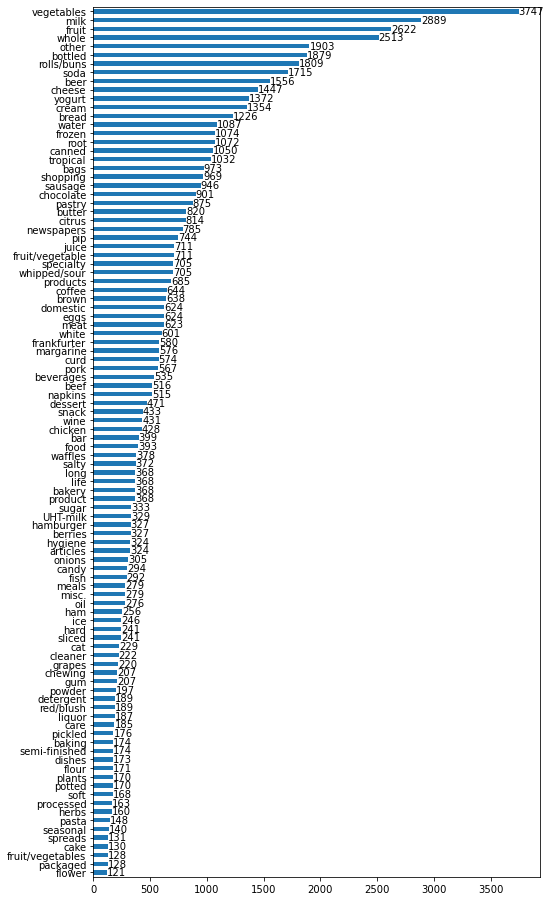

In [29]:
baskets_arr = [x for b in baskets for x in b]
histogram(baskets_arr, N=100)

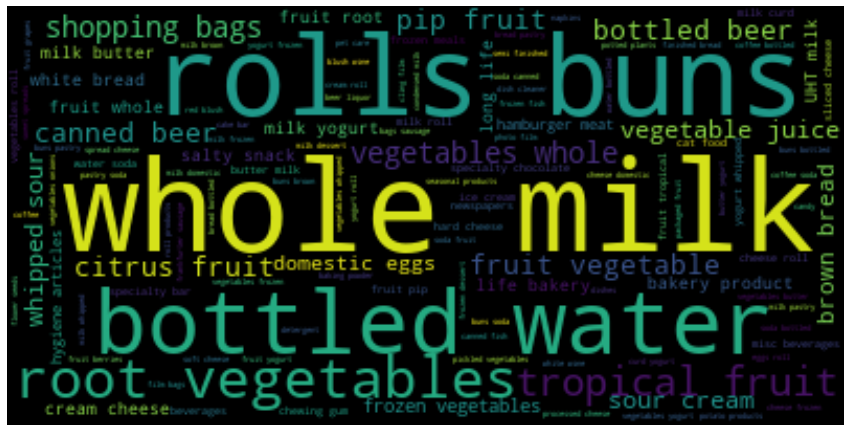

In [30]:
word_cloud(baskets_arr)

We can compare the results of the matrix multiplication with the one-frequencies obtained before, stored in **one_item_freq**. We can clearly see that this one-item frequencies are stored in the diagonal of the **data_freq** dataframe. The rest of the items combinations are stored in the coordinates combinations.

In [31]:
print(one_item_freq[:5])

abrasive cleaner      35
soda                1715
nut snack             31
chewing gum          207
butter               545
dtype: int64


We can get the one-item frequency for *beef* getting the diagonal coordinate.

In [32]:
data_freq.loc["beef","beef"]

516

Now we can get the two-item frequency between *beef* and *white wine*.

In [33]:
data_freq.loc["beef", "white wine"]

11

## Support Dataframe

If we divide each value of the **data_freq** dataframe by $N$ we obtain **data_support** which is a matrix that has the $Support(X)$ value for each item at it's diagonal and the $Support(X,Y)$ value in the other coordinates combination.

In [34]:
data_support = data_freq/N
data_support[:6]

,abrasive cleaner,soda,nut snack,chewing gum,butter,grapes,male cosmetics,white bread,white wine,dessert,...,potted plants,shopping bags,whisky,specialty bar,soap,condensed milk,organic sausage,canned vegetables,chicken,decalcifier
abrasive cleaner,0.003559,0.000610,0.000000,0.000102,0.000508,0.000102,0.000000,0.000305,0.000102,0.000203,...,0.000000,0.000305,0.000000,0.000000,0.000102,0.000102,0.000102,0.000203,0.000508,0.000000
soda,0.000610,0.174377,0.001017,0.005389,0.008846,0.004067,0.000915,0.010269,0.003660,0.009863,...,0.002745,0.024606,0.000000,0.007219,0.000813,0.002135,0.000407,0.003050,0.008338,0.000203
nut snack,0.000000,0.001017,0.003152,0.000000,0.000203,0.000102,0.000000,0.000102,0.000000,0.000305,...,0.000000,0.000610,0.000000,0.000203,0.000000,0.000305,0.000000,0.000000,0.000102,0.000000
chewing gum,0.000102,0.005389,0.000000,0.021047,0.000915,0.000712,0.000305,0.001118,0.000508,0.000813,...,0.000305,0.003254,0.000102,0.000813,0.000000,0.000000,0.000203,0.000102,0.000813,0.000203
butter,0.000508,0.008846,0.000203,0.000915,0.055414,0.002440,0.000305,0.004270,0.001118,0.002745,...,0.001423,0.004982,0.000102,0.001525,0.000102,0.000813,0.000508,0.000813,0.005796,0.000203
grapes,0.000102,0.004067,0.000102,0.000712,0.002440,0.022369,0.000000,0.001017,0.000813,0.001322,...,0.001322,0.002440,0.000000,0.001220,0.000000,0.000102,0.000102,0.000102,0.001729,0.000102


Now we can get the values of the following supports:
* $Support(beef)$
* $Support(white \: wine)$
* $Support(beef \rightarrow white \: wine)$

In [35]:
print(data_support.loc["beef", "beef"])
print(data_support.loc["white wine", "white wine"])
print(data_support.loc["beef", "white wine"])

0.05246568378240976
0.019013726487036097
0.0011184544992374173


## Lift Dataframe

Iterating we can get the Lift Matrix **data_lift** where we get in each cell combination of the matrix the lift value between those items.

In [36]:
data_lift = create_association_dataset(data_support=data_support, verbose=0)
data_lift[:6]

,abrasive cleaner,soda,nut snack,chewing gum,butter,grapes,male cosmetics,white bread,white wine,dessert,...,potted plants,shopping bags,whisky,specialty bar,soap,condensed milk,organic sausage,canned vegetables,chicken,decalcifier
abrasive cleaner,0.000000,0.983090,0.000000,1.357488,2.577982,1.277273,0.000000,2.036232,1.502674,1.539726,...,0.000000,0.869969,0.000000,0.000000,10.807692,2.782178,12.772727,5.301887,3.329384,0.000000
soda,0.983090,0.000000,1.849901,1.468303,0.915447,1.042672,1.146939,1.399044,1.104005,1.524015,...,0.910804,1.432194,0.000000,1.513618,1.764521,1.192362,1.042672,1.623027,1.114324,0.764626
nut snack,0.000000,1.849901,0.000000,0.000000,1.164250,1.442082,0.000000,0.766324,0.000000,2.607601,...,0.000000,1.964446,0.000000,2.358796,0.000000,9.423507,0.000000,0.000000,0.751796,0.000000
chewing gum,1.357488,1.468303,0.000000,0.000000,0.784603,1.511748,3.167472,1.262398,1.270376,1.041361,...,0.838448,1.569026,5.939010,1.412999,0.000000,0.000000,4.319280,0.448227,0.900703,6.334944
butter,2.577982,0.915447,1.164250,0.784603,0.000000,1.968641,1.203058,1.830741,1.061522,1.334900,...,1.486131,0.912536,2.255734,1.006275,0.694072,1.429376,4.101334,1.361953,2.437476,2.406116
grapes,1.277273,1.042672,1.442082,1.511748,1.968641,0.000000,0.000000,1.079820,1.912494,1.592217,...,3.418583,1.107233,0.000000,1.994255,0.000000,0.442619,2.032025,0.421741,1.800894,2.980303


We confirm the **data_lift** values.

In [37]:
data_lift.loc["beef", "white wine"] # 1.1211810305517553

1.1211810305517553

In [38]:
# Lift between beef and white wine
(data_support.loc["beef", "white wine"])/(data_support.loc["beef", "beef"] * data_support.loc["white wine", "white wine"]) # 1.1211810305517553

1.1211810305517553

## Leverage Dataframe

Iterating we can get the Leverage Matrix **data_leverage** where we get in each cell combination of the matrix the leverage value between those items.

In [39]:
data_leverage = create_association_dataset(data_support=data_support, verbose=1)
data_leverage[:6]

,abrasive cleaner,soda,nut snack,chewing gum,butter,grapes,male cosmetics,white bread,white wine,dessert,...,potted plants,shopping bags,whisky,specialty bar,soap,condensed milk,organic sausage,canned vegetables,chicken,decalcifier
abrasive cleaner,0.000000,-0.000010,-0.000011,0.000027,0.000311,0.000022,-0.000016,0.000155,0.000034,0.000071,...,-0.000062,-0.000046,-0.000003,-0.000097,0.000092,0.000065,0.000094,0.000165,0.000356,-0.000005
soda,-0.000010,0.000000,0.000467,0.001719,-0.000817,0.000166,0.000117,0.002929,0.000345,0.003391,...,-0.000269,0.007425,-0.000142,0.002450,0.000352,0.000344,0.000017,0.001171,0.000855,-0.000063
nut snack,-0.000011,0.000467,0.000000,-0.000066,0.000029,0.000031,-0.000014,-0.000031,-0.000060,0.000188,...,-0.000054,0.000300,-0.000003,0.000117,-0.000008,0.000273,-0.000007,-0.000034,-0.000034,-0.000005
chewing gum,0.000027,0.001719,-0.000066,0.000000,-0.000251,0.000241,0.000209,0.000232,0.000108,0.000032,...,-0.000059,0.001180,0.000085,0.000238,-0.000056,-0.000216,0.000156,-0.000125,-0.000090,0.000171
butter,0.000311,-0.000817,0.000029,-0.000251,0.000000,0.001201,0.000051,0.001938,0.000065,0.000689,...,0.000466,-0.000478,0.000057,0.000010,-0.000045,0.000244,0.000384,0.000216,0.003418,0.000119
grapes,0.000022,0.000166,0.000031,0.000241,0.001201,0.000000,-0.000102,0.000075,0.000388,0.000492,...,0.000935,0.000236,-0.000018,0.000608,-0.000059,-0.000128,0.000052,-0.000139,0.000769,0.000068


We confirm the results using the **data_support** values.

In [40]:
data_leverage.loc["beef", "white wine"] # 0.00012088633784335264

0.00012088633784335264

In [41]:
# Leverage between beef and white wine
data_support.loc["beef", "white wine"]-(data_support.loc["beef", "beef"] * data_support.loc["white wine", "white wine"]) # 0.00012088633784335264

0.00012088633784335264

## Shelves

There are 7 shelves which have 15 items already arranged. We have to get the list of the remaining 64 items (from the 169 list) that we have to decide their placement.

In [42]:
shelf1 = ['shopping bags','newspapers','long life bakery product','cling film/bags','flower (seeds)','pet care','photo/film','candles','dog food','rice','instant coffee','kitchen towels','light bulbs','preservation products','sound storage medium']
shelf2 = ['soda','bottled water','bottled beer','canned beer','fruit/vegetable juice','red/blush wine','white wine','liquor','sparkling wine','rum','brandy','cocoa drinks','prosecco','liqueur','whisky']
shelf3 = ['rolls/buns','sausage','pastry','brown bread','frankfurter','pork','beef','white bread','waffles','hamburger meat','zwieback','cereals','syrup','fish','honey']
shelf4 = ['napkins','hygiene articles','softener','cleaner','male cosmetics','abrasive cleaner','skin care','bathroom cleaner','decalcifier','hair spray','make up remover','toilet cleaner','baby cosmetics','kitchen utensil','baby food']
shelf5 = ['chocolate','salty snack','specialty chocolate','candy','specialty bar','chewing gum','cake bar','chocolate marshmallow','popcorn','nuts/prunes','artif. sweetener','snack products','cookware','cooking chocolate','pudding powder']
shelf6 = ['other vegetables','root vegetables','tropical fruit','citrus fruit','pip fruit','sauces','spices','ketchup','tea','canned fruit','potato products','organic sausage','ready soups','specialty vegetables','salad dressing']
shelf7 = ['whole milk','yogurt','butter','curd','frozen meals','spread cheese','frozen dessert','condensed milk','specialty cheese','frozen potato products','finished products','curd cheese','cream','frozen fruits','frozen chicken']
shelves = [shelf1, shelf2, shelf3, shelf4, shelf5, shelf6, shelf7]
placed_items = shelf1+shelf2+shelf3+shelf4+shelf5+shelf6+shelf7

The **SKUs** list has the 169 (total) items. The **placed_items** list has 105 already placed items in the shelves. We get the **unplaced_items** list which will have the 64 remaining items that are left to be placed.

In [43]:
unplaced_items = []
for item in SKUs:
    if item not in placed_items:
        unplaced_items.append(item)

In [44]:
print("Number of total items:", len(SKUs))
print("Number of already placed items:", len(placed_items))
print("Number of items left to be placed:", len(unplaced_items))

Number of total items: 169
Number of already placed items: 105
Number of items left to be placed: 64


## Complete Dataframe

With all the matrices that we created that sum up the values for **freqcuency**, **support**, **lift**, **leverage** for all the combination of items and the information if the items are already placed or unplaced in the shelves we can create a single dataframe that gathers all this information. The **complete_data** dataframe has 1 row for each combination of two products (without repetition) and 1 column for each of this values of interest.

We create a list for each of the variables of the dataframe and we iterate for each combination of two products to get the corresponded values.

In [45]:
index_list = []
item_comb_list = []
item1_list = []
item2_list = []
n_item_list = []
frequency_list = []
support_list = []
lift_list = []
leverage_list = []
type_item_list = []
type1_list = []
type2_list = []
i_list = []

In [46]:
# The i and j variables take each item name
for i in SKUs:
    for j in SKUs:
        # We reset the type value for each variable (needed later)
        i_type = 0
        j_type = 0
        if j not in i_list:
            # The index for the dataframe is the sum of the product names
            index_list.append(i+"+"+j)
            # We get the values for unique items
            if i == j:
                item_comb_list.append([i])
                item1_list.append(i)
                item2_list.append(None)
                n_item_list.append(1)
                frequency_list.append(data_freq.loc[i,j])
                support_list.append(data_support.loc[i,j])
                lift_list.append(data_lift.loc[i,j])
                leverage_list.append(data_leverage.loc[i,j])
                if i in placed_items:
                    i_type = "placed"
                elif i in unplaced_items:
                    i_type = "unplaced"
                type_item_list.append([i_type])
                type1_list.append(i_type)
                type2_list.append(None)
            # We get the values for combinations of items
            if i != j:
                item_comb_list.append([i,j])
                item1_list.append(i)
                item2_list.append(j)
                n_item_list.append(2)
                frequency_list.append(data_freq.loc[i,j])
                support_list.append(data_support.loc[i,j])
                lift_list.append(data_lift.loc[i,j])
                leverage_list.append(data_leverage.loc[i,j])
                if i in placed_items:
                    i_type = "placed"
                elif i in unplaced_items:
                    i_type = "unplaced"
                if j in placed_items:
                    j_type = "placed"
                elif j in unplaced_items:
                    j_type = "unplaced"
                type_item_list.append([i_type, j_type])
                type1_list.append(i_type)
                type2_list.append(j_type)
    # Everytime we change i we save it in i_list to avoid repited combinations of items
    i_list.append(i)

With the completed lists we can create the **data_complete** dataframe.

In [47]:
data_complete = pd.DataFrame({"Item_Comb" : item_comb_list,
                              "Item_1" : item1_list,
                              "Item_2" : item2_list,
                             "n_Items" : n_item_list,
                             "Frequency" : frequency_list,
                             "Support" : support_list,
                             "Lift" : lift_list,
                             "Leverage" : leverage_list,
                             "Item_Type" : type_item_list,
                             "Type_Item_1" : type1_list,
                             "Type_Item_2" : type2_list})
#data_complete.index = index_list

We create a function to generate two new columns, to indicate in which shelf the Item is placed.

In [48]:
data_complete["Shelf_Item_1"] = data_complete.apply(lambda x: shelf_func(x["Item_1"]), axis = 1)
data_complete["Shelf_Item_2"] = data_complete.apply(lambda x: shelf_func(x["Item_2"]), axis = 1)

In [49]:
data_complete.head()

,Item_Comb,Item_1,Item_2,n_Items,Frequency,Support,Lift,Leverage,Item_Type,Type_Item_1,Type_Item_2,Shelf_Item_1,Shelf_Item_2
0,[abrasive cleaner],abrasive cleaner,None,1,35,0.003559,0.000000,0.000000,[placed],placed,None,shelf 4,None
1,"[abrasive cleaner, soda]",abrasive cleaner,soda,2,6,0.000610,0.983090,-0.000010,"[placed, placed]",placed,placed,shelf 4,shelf 2
2,"[abrasive cleaner, nut snack]",abrasive cleaner,nut snack,2,0,0.000000,0.000000,-0.000011,"[placed, unplaced]",placed,unplaced,shelf 4,no shelf
3,"[abrasive cleaner, chewing gum]",abrasive cleaner,chewing gum,2,1,0.000102,1.357488,0.000027,"[placed, placed]",placed,placed,shelf 4,shelf 5
4,"[abrasive cleaner, butter]",abrasive cleaner,butter,2,5,0.000508,2.577982,0.000311,"[placed, placed]",placed,placed,shelf 4,shelf 7


## Single Item Analysis

Now we can start to understand how single items behave. First we filter for **n Items** = 1 and sort them for **Support**. We can keep the useful columns for single items.

In [50]:
one_item_data = data_complete[data_complete["n_Items"] == 1]
one_item_data = one_item_data[["Item_1", "Frequency", "Support", "Type_Item_1", "Shelf_Item_1"]]

In [51]:
one_item_data.shape

(169, 5)

In [52]:
one_item_data.head(20)

,Item_1,Frequency,Support,Type_Item_1,Shelf_Item_1
0,abrasive cleaner,35,0.003559,placed,shelf 4
169,soda,1715,0.174377,placed,shelf 2
337,nut snack,31,0.003152,unplaced,no shelf
504,chewing gum,207,0.021047,placed,shelf 5
670,butter,545,0.055414,placed,shelf 7
835,grapes,220,0.022369,unplaced,no shelf
999,male cosmetics,45,0.004575,placed,shelf 4
1162,white bread,414,0.042095,placed,shelf 3
1324,white wine,187,0.019014,placed,shelf 2
1485,dessert,365,0.037112,unplaced,no shelf


### Placed Items Analysis

Now we are able to get the mean or median **Frequency** and **Support** for each Shelf, which can help us to know which is the least and most visited Shelf.

We can gather the same information using a bar plot. First we get the plot for the median support. We can see a big difference between Shelf 3 and the rest.

In [53]:
(one_item_data[one_item_data["Type_Item_1"] == "placed"].
 groupby("Shelf_Item_1").
 agg(["mean", "median", "min", "max"]))

Frequency                    Support                      \
                    mean median min   max      mean    median       min   
Shelf_Item_1                                                              
shelf 1       196.200000     88   1   969  0.019949  0.008948  0.000102   
shelf 2       383.533333    109   8  1715  0.038997  0.011083  0.000813   
shelf 3       481.866667    414  15  1809  0.048995  0.042095  0.001525   
shelf 4        75.800000     27   1   515  0.007707  0.002745  0.000102   
shelf 5       159.266667     89  23   488  0.016194  0.009049  0.002339   
shelf 6       391.666667     42   8  1903  0.039824  0.004270  0.000813   
shelf 7       390.800000    101   6  2513  0.039736  0.010269  0.000610   

                        
                   max  
Shelf_Item_1            
shelf 1       0.098526  
shelf 2       0.174377  
shelf 3       0.183935  
shelf 4       0.052364  
shelf 5       0.049619  
shelf 6       0.193493  
shelf 7       0.255516

In [54]:
df_plot_median = get_dfplot(kind='median', target_subset='Shelf', sort_by='Support', ascending=False, item_status='placed')
df_plot_mean   = get_dfplot(kind='mean', target_subset='Shelf', sort_by='Support', ascending=False, item_status='placed')

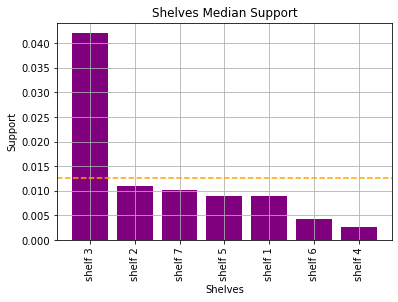

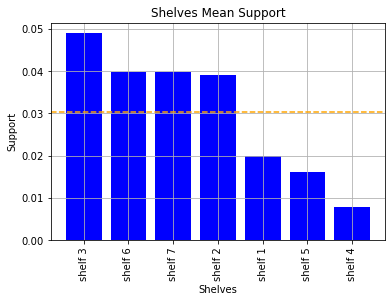

In [55]:
FIGSIZE = (6, 4)
simple_plot(X=df_plot_median['Shelf'], y=df_plot_median['Support'],
            title='Shelves Median Support', X_label='Shelves', y_label='Support', kind='bar', figsize=FIGSIZE, color='purple')

simple_plot(X=df_plot_mean['Shelf'], y=df_plot_mean['Support'],
            title='Shelves Mean Support', X_label='Shelves', y_label='Support', kind='bar', figsize=FIGSIZE, color='blue')

When we plot for the mean value Shelves 6, 7 and 2 get closer to 3.

The items in each shelf have very asymmetric distribution and the mean for Shelves 6, 7 and 2 are affected by few items with very large support. Shelves 1, 5 and 4 are the least visited shelves, as they have low mean and median with low max values. This shelves will be benefit by items with Support higher than their mean.

Another way of comparing shelves support distribution is using boxplots. Here we compare the values for the placed items.

We can add the unplaced items to the boxplot analysis.

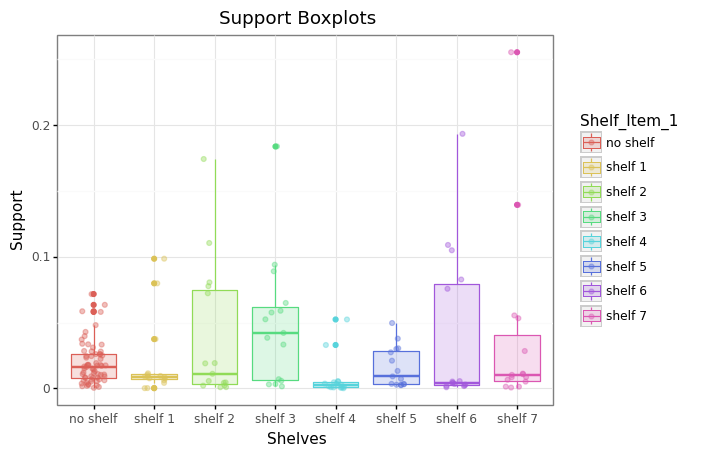

<ggplot: (8768859583407)>

In [56]:
plot_data = one_item_data

(ggplot(plot_data, aes(x = "Shelf_Item_1", y = "Support", color = "Shelf_Item_1", fill = "Shelf_Item_1"))+
     geom_boxplot(alpha = 0.2)+
     geom_jitter(alpha = 0.4, width = 0.2)+
     labs(title = "Support Boxplots",
         x = "Shelves",
         y = "Support")+
     theme_bw()
)

We can inspect which are the placed items with the biggest single item support value.

In the next bar plot we can confirm items in shelves 1, 4 and 5 have less representation in the biggest suport.

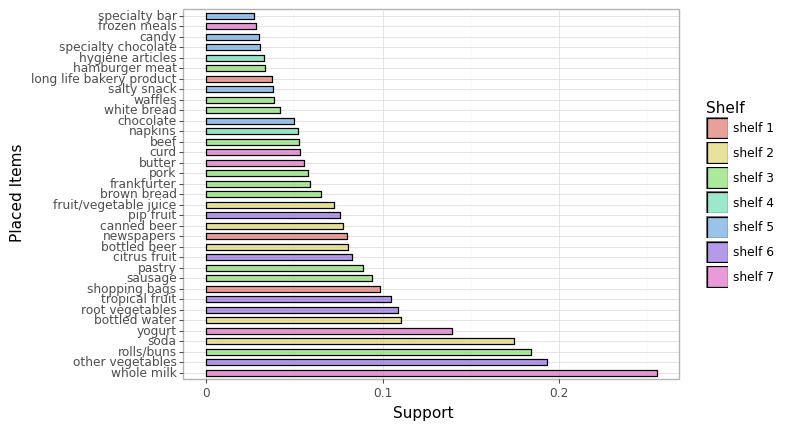

<ggplot: (8768859627292)>

In [57]:
df_histogram_palced = get_dfplot(kind=None, target_subset='Item_1', sort_by='Support', item_status='placed', ascending=False)

(ggplot(df_histogram_palced.head(35), aes(x = "Item_1", y = "Support", fill = "Shelf_Item_1"))+
     geom_col(alpha = 0.6, color = "black", width = 0.6)+
     coord_flip()+
     labs(x = "Placed Items",
         fill = "Shelf")+
     theme_light()
)

### Unplaced Items Analysis

We can see the first 30 **unplaced** single items ordered descending by Support.

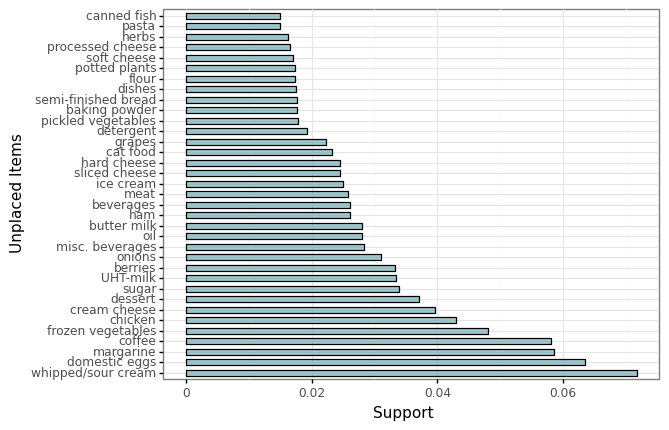

<ggplot: (8768859637697)>

In [58]:
df_histogram_unplaced = get_dfplot(kind=None, target_subset='Item_1', sort_by='Support', item_status='unplaced', ascending=False)

(ggplot(df_histogram_unplaced.head(35), aes(x = "Item_1", y = "Support"))+
     geom_col(alpha = 0.6, color = "black", width = 0.6,fill = "#61A4AD")+
     coord_flip()+
     labs(x = "Unplaced Items")+
     theme_bw()
)

## Two Items Analysis

We can see that the **data_complete** and **two_item_data** were built to have each item combination just one. This way, for two item combination we should have the following combinatorial number:

$$\binom{169}{2}=14196$$


In [59]:
two_item_data = (data_complete[data_complete["n_Items"]==2].drop(["Item_Comb","n_Items", "Item_Type"], axis = 1))

We create a function to generate a new column to show the number of unplaced items in the combination.

In [60]:
def unplaced_func(col1, col2):
    if (col1 == "unplaced") & (col2 == "unplaced"):
        return 2
    elif (col1 == "unplaced") | (col2 == "unplaced"):
        return 1
    else:
        return 0

In [61]:
two_item_data["n_unplaced"] = two_item_data.apply(lambda x: unplaced_func(x["Type_Item_1"], x["Type_Item_2"]), axis = 1)
two_item_data

,Item_1,Item_2,Frequency,Support,Lift,Leverage,Type_Item_1,Type_Item_2,Shelf_Item_1,Shelf_Item_2,n_unplaced
1,abrasive cleaner,soda,6,0.000610,0.983090,-0.000010,placed,placed,shelf 4,shelf 2,0
2,abrasive cleaner,nut snack,0,0.000000,0.000000,-0.000011,placed,unplaced,shelf 4,no shelf,1
3,abrasive cleaner,chewing gum,1,0.000102,1.357488,0.000027,placed,placed,shelf 4,shelf 5,0
4,abrasive cleaner,butter,5,0.000508,2.577982,0.000311,placed,placed,shelf 4,shelf 7,0
5,abrasive cleaner,grapes,1,0.000102,1.277273,0.000022,placed,unplaced,shelf 4,no shelf,1
...,...,...,...,...,...,...,...,...,...,...,...
14357,organic sausage,chicken,2,0.000203,2.118699,0.000107,placed,unplaced,shelf 6,no shelf,1
14358,organic sausage,decalcifier,0,0.000000,0.000000,-0.000003,placed,placed,shelf 6,shelf 4,0
14360,canned vegetables,chicken,8,0.000813,1.758920,0.000351,unplaced,unplaced,no shelf,no shelf,2
14361,canned vegetables,decalcifier,0,0.000000,0.000000,-0.000016,unplaced,placed,no shelf,shelf 4,1


# Shelf Selection Algorithm

For the shelves selection of the 64 unplaced items we are going to use an score for each shelf. We decided to multiply the Support values for a factor or weight of 100 and Leverage values for a factor or weight of 500 (to add more weight in the shelves score). The selection for the multiplying factors was made trying different values until we find this were usefull.

The score for each shelf will be the sum of every single item Support score (support * 100) value in it and the sum of all the in-between leverage score (leverage * 500) for the shelf. This means that the Leverage Score for Shelf 1 (for example) it is a sum of 15 items Leverage value within the Shelf 1 items. Note that each Leverage value is sumed just one time (Leverage(X,Y) = Leverage(Y,X)).

$${Total\:Score_{Shelf_(i)}=\sum_{j=1}^{15}{(Support(Item_{(j \: in \: i)}*100)}+\sum_{j=1}\sum_{k=1}{(Leverage(Item_{(j \: in \: i)},Item_{(k \: in \: i)})*500)}}$$

In the formula to get the Total Score of 1 shelf we sum the Support Value from the 15 items in that shelf and multiply that amount by the support weight or factor (100). Then we add the Leverage value between the 15 items with the 14 left in that shelf, multiplied by the leverage weight (500). This means that the leverage score is greater for a shelf in which it's items have high leverage in between (highly correlated). 

In [62]:
# Multiplying factor for Support and Leverage Scores
p_sup = 100
p_lev = 500

We can check for the placed items, how the distribution for **Support Score** for each shelf. The **sum** column represents the support score value. The support score for each shelf can be extracted from the **one_item_data**.

We generate a list having the value for the **Support Score** and another list with the **Leverage Score** for each shelf. The Leverage Score it's calculated in the **two_item_data** which has all the combinations of items with the leverage values. We get from that dataframe just the combinations of items that **share** the same shelf.

In [63]:
shelves_sup = (one_item_data.
 query('Type_Item_1 == "placed"').
 assign(Support_Score = one_item_data["Support"] * p_sup).
 groupby("Shelf_Item_1").
 agg({"Support_Score": "sum"})
)

shelves_lev = (two_item_data.
 query('n_unplaced == 0').
 query('Shelf_Item_1 == Shelf_Item_2').
 assign(Leverage_Score = two_item_data["Leverage"] * p_lev).
 groupby("Shelf_Item_1").
 agg({"Leverage_Score":"sum"})
)

We can generate the dataframe **shelves_score** with the current Support, Leverage and Total Score for each shelf. This dataframe shows the score of the shelves without the assignment of the unplaced items.

In [64]:
shelves_score = pd.DataFrame({"Shelf":shelves_sup.index,
                             "Support_Score_placed":shelves_sup["Support_Score"],
                             "Leverage_Score_placed": shelves_lev["Leverage_Score"]})

shelves_score = (shelves_score.
                 assign(Total_Score_placed = shelves_score["Support_Score_placed"] + shelves_score["Leverage_Score_placed"]))

shelves_score

,Shelf,Support_Score_placed,Leverage_Score_placed,Total_Score_placed
Shelf_Item_1,,,,
shelf 1,shelf 1,29.923742,4.179976,34.103718
shelf 2,shelf 2,58.495170,23.885928,82.381098
shelf 3,shelf 3,73.492628,56.444569,129.937197
shelf 4,shelf 4,11.560752,4.761751,16.322504
shelf 5,shelf 5,24.290798,14.059594,38.350392
shelf 6,shelf 6,59.735638,70.328566,130.064204
shelf 7,shelf 7,59.603457,46.291848,105.895305


We can plot the **Support Score**, **Leverage Score** and the **Total Score** for each shelf in a bar plot. We also include the mean value for those scores in a red dashed line. We can see from this plots a similar picture from the support values plots for each shelf, where shelves 6, 7 and 3 have the maximum values and shelves 1, 4 and 5 lower values. The objective of our unplaced item assignment is to balance this shelves scores, so least visited shelves get higher support and leverage mean value and clients walk and stop in every shelf.

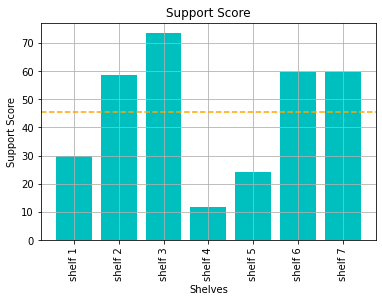

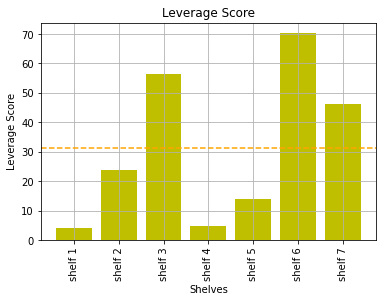

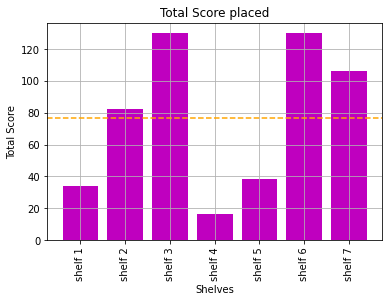

In [65]:
simple_plot(X=shelves_score['Shelf'], y=shelves_score['Support_Score_placed'], 
            title='Support Score', X_label='Shelves', y_label='Support Score', figsize=FIGSIZE, kind='bar', color='c')

simple_plot(X=shelves_score['Shelf'], y=shelves_score['Leverage_Score_placed'], 
            title='Leverage Score', X_label='Shelves', y_label='Leverage Score', figsize=FIGSIZE, kind='bar', color = 'y')

simple_plot(X=shelves_score['Shelf'], y=shelves_score['Total_Score_placed'], 
            title='Total Score placed', X_label='Shelves', y_label='Total Score', figsize=FIGSIZE, kind='bar', color='m')

We can clearly see how shelves 1, 4 and 5 have a really low total score, while shelves 3, 6 and 7 get really high total score. This is similiar to the results we've got when measuring the median Supporg for the shelves, so the objective is to balance the Total Score (by adding the new items) to balance the metrics between shelves.

---

## Root Mean Total Score 

The main objective is to balance Sheves Total Score adding the unplaced items, so the store gets a better distribution of high Support (most buyed items) and high Leverage (items correlations). To get an optimal solution for this problem we should create a metric that represents the unbalance or difference between shelves Total Score and assign the unplaced items to minimize this metric.


Root Mean Total Score represents a metric of the unbalance or distance of the Total Score from the shelves. If shelves Total Score are really different to it's mean value implies that their scores are very unbalanced. If this metric has a lower value means the sum of the difference of the Total Scores is lower and we get a more balanced solution.

$$RMTS = \sqrt{\frac{\sum{(TS_{shelfi}-\bar{TS}_{shelf})^2}}{7}}$$

We create a function to calculate the **RMTS** metric.

In [66]:
def RMTS (col): #MRE
    x = np.sqrt(((col-col.mean())**2).mean())
    return x

Now we can calculate the **RMTS** value for the actual shelves (only placed items). We want to reduce this value by assigning the unplaced items in a way that minimizes this metric.

In [67]:
total_score_placed = shelves_score["Total_Score_placed"]

print(f'{RMTS(total_score_placed)}')

43.910871451586104


## Unplaced Items Score

Now we can start getting the unplaced data scores. In the first place, we get the **Support Score** for every unplaced item.

In [68]:
unplaced_data = (one_item_data.
 query('Type_Item_1 == "unplaced"').
 assign(Support_Score_unplaced = one_item_data["Support"] * p_sup).
 filter(["Item_1", "Support_Score_unplaced"])
)
unplaced_data.head()

,Item_1,Support_Score_unplaced
337,nut snack,0.315201
835,grapes,2.236909
1485,dessert,3.711235
1962,misc. beverages,2.836807
2119,soft cheese,1.708185


Now we can iterate to get the **Leverage Score** for each unplaced item, with each shelf (sum of leverage score between the unplaced item and all the items in the shelf). We get 7 new columns having the Leverage Score for each shelf (S1, S2,...,S7) and the max and min shelf by leverage value.

In [69]:
index = []
shelf_lev = np.zeros([64, 7])
lev_shelf = np.zeros(15)
i = 0

for unplaced in unplaced_items:
    index.append(unplaced)
    j = 0
    for shelf in shelves:
        k = 0
        for placed in shelf:
            lev_shelf[k] = data_leverage.loc[unplaced, placed] * p_lev
            k = k + 1
        shelf_lev[i, j] = np.sum(np.array(lev_shelf))
        j = j + 1
    i = i + 1
shelf_lev = pd.DataFrame(shelf_lev)
leverage_cols = ["Lev_Score_S1", "Lev_Score_S2", "Lev_Score_S3", "Lev_Score_S4", "Lev_Score_S5", "Lev_Score_S6", "Lev_Score_S7"]
shelf_lev.columns = leverage_cols
shelf_lev["Lev_Max"] = shelf_lev[leverage_cols].idxmax(axis=1)
shelf_lev["Lev_Min"] = shelf_lev[leverage_cols].idxmin(axis=1)
shelf_lev = shelf_lev.assign(Item_1 = index)
shelf_lev.head()

,Lev_Score_S1,Lev_Score_S2,Lev_Score_S3,Lev_Score_S4,Lev_Score_S5,Lev_Score_S6,Lev_Score_S7,Lev_Max,Lev_Min,Item_1
0,0.189306,0.450762,0.621113,0.122835,0.379759,0.431213,0.331618,Lev_Score_S3,Lev_Score_S4,nut snack
1,1.381178,1.591796,4.744088,0.994730,1.909519,7.706233,3.450554,Lev_Score_S6,Lev_Score_S4,grapes
2,3.445772,2.821181,7.765730,1.616841,3.169221,7.013977,7.496054,Lev_Score_S3,Lev_Score_S4,dessert
3,0.839490,3.548474,-1.324069,0.647966,1.689307,1.135616,1.205204,Lev_Score_S2,Lev_Score_S3,misc. beverages
4,1.867215,0.392888,5.721016,0.436092,1.280705,5.218308,5.992181,Lev_Score_S7,Lev_Score_S2,soft cheese


We add this new columns to the unplaced data.

In [70]:
unplaced_data = unplaced_data.merge(shelf_lev, how = "left", on = "Item_1")
unplaced_data.sort_values("Support_Score_unplaced", ascending = False).head()

,Item_1,Support_Score_unplaced,Lev_Score_S1,Lev_Score_S2,Lev_Score_S3,Lev_Score_S4,Lev_Score_S5,Lev_Score_S6,Lev_Score_S7,Lev_Max,Lev_Min
37,whipped/sour cream,7.168277,4.475731,-1.748396,10.669902,3.939842,3.291808,20.684482,20.528502,Lev_Score_S6,Lev_Score_S2
44,domestic eggs,6.344687,4.335325,2.541441,14.306355,3.195776,2.512731,16.992863,16.068858,Lev_Score_S6,Lev_Score_S5
36,margarine,5.856634,3.540379,2.545390,12.134340,2.206917,1.631164,12.553265,11.778550,Lev_Score_S6,Lev_Score_S5
32,coffee,5.805796,4.887414,1.626466,4.746166,1.677077,1.794588,4.469217,5.727720,Lev_Score_S7,Lev_Score_S2
15,frozen vegetables,4.809354,3.480463,1.744679,7.899332,2.608929,1.937190,13.240998,12.662717,Lev_Score_S6,Lev_Score_S2


We can see how most unplaced items have biggest leverage score value with the items in shelves 3, 6 and 7. This can be helpful, as it means that unplaced items are generally positively correlated with this shelves (3,6,7) that already have a high total score. The unplaced items with the highest support score can be assigned to the shelves with lowest total score (1,4,5) and will keep high correlation with the most visited shelves.

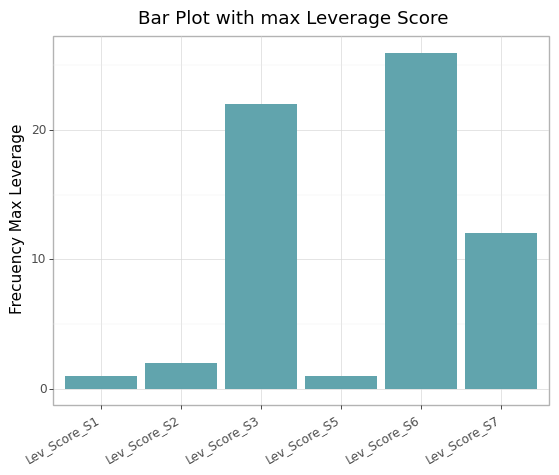

<ggplot: (8768860781129)>

In [71]:
(ggplot(unplaced_data, aes(x = "Lev_Max"))+
 geom_bar(fill = "#61A4AD")+
 labs(title = "Bar Plot with max Leverage Score",
     x = "",
     y = "Frecuency Max Leverage")+
 theme_light()+
 theme(axis_text_x=element_text(rotation=30, hjust=1))
)

Now we can run the algorithm to assign the unplaced items to the shelves. We are going to use some multiplying factors or **weights** to control how the items are distributed. We sort the **unplaced_data** by Support Score in descending order. This will make the items with highest Support Score to be assigned first.

Next we decide to which shelf is assigned by maximum Leverage Score * w_X (where w_X is the multiplying factor or weight for each shelf). As we've seen before, unplaced items have higher Leverage Score values with shelves 3, 6 and 7 which are already the ones with the higher score. Assigning the unplaced items by Leverage Score without any weight will assign the first items (with higher Support Score) to this shelves, making the distribution of Support Score and Leverage Score more unbalanced. 

To make the assignment more balanced we should set higher weights for the Leverage Score in shelves 1, 4 and 5 (weight greater than 1) and lower weights in the Leverage Score in shelves 3, 6 and 7 (weight between 0 and 1). This weights for the Leverage Score only affects this value when choosing the shelf, not the Leverage Score that will sum to the Total Score of the shelf.

How do we decide the best values for each of the 7 shelves? The algorithm that we design is able to take a matrix (the **weight_matrix**) that has some values for each weight and creates the metric with all the posible combinations of weights.

To keep the number of items in each shelf balanced, a maximum of 10 unplaced items can be assigned to each shelf.

We can see the weight factors that apply on the Leverage Score with the Shelf 1. In this case we multiply by 1, 1.25 or 1.5 the Leverage Score for Shelf 1 for each unplaced item.

In [72]:
weight_matrix  = {
    'w_1': [1.5, 1.1 , 1.25],
    'w_2': [0.9, 0.5, 0.65],
    'w_3': [0.8, 0.01, 0.025],
    'w_4': [1.4, 1.85, 1.9],
    'w_5': [1.05, 1.3, 1.4],
    'w_6': [0.1, 0.01, 0.025],
    'w_7': [0.02, 0.05, 0.1]
}

order = weight_matrix.keys()
weight_matrix = pd.DataFrame(itertools.product(*[weight_matrix[k] for k in order]), columns=order)
weight_matrix = weight_matrix.to_numpy()
weight_matrix

array([[1.5  , 0.9  , 0.8  , ..., 1.05 , 0.1  , 0.02 ],
       [1.5  , 0.9  , 0.8  , ..., 1.05 , 0.1  , 0.05 ],
       [1.5  , 0.9  , 0.8  , ..., 1.05 , 0.1  , 0.1  ],
       ...,
       [1.25 , 0.65 , 0.025, ..., 1.4  , 0.025, 0.02 ],
       [1.25 , 0.65 , 0.025, ..., 1.4  , 0.025, 0.05 ],
       [1.25 , 0.65 , 0.025, ..., 1.4  , 0.025, 0.1  ]])

In [73]:
shelf_name = np.array(["shelf 1", "shelf 2", "shelf 3", "shelf 4", "shelf 5", "shelf 6", "shelf 7"])


Lev_Scores = (unplaced_data.
              sort_values("Support_Score_unplaced", ascending = False).
              filter(["Lev_Score_S1", "Lev_Score_S2", "Lev_Score_S3", "Lev_Score_S4", "Lev_Score_S5", "Lev_Score_S6", "Lev_Score_S7"]).
              to_numpy())

cont = 0


# The algorithm iterates for each row of the weight_matrix.
# Each row of the weight_matrix is a set of 7 weights for each shelf.
for weight in weight_matrix:
    
    # For each set of 7 weights we reset the shelf assigned and the leverage score.
    # shelf_n_items is set to zero and counts how many items are assigned to each shelf, never greater than 10.
    assigned_shelf = [0]*64
    leverage_score = [0]*64
    shelf_n_items = np.zeros(7)
    
    # For the first set of weights (row 0 of the weight_matrix) we save it's values as the best solution.
    if cont == 0:
        
        # We create the lists that will have the assigned shelves and Leverage Score for each unplaced item.
        assigned_shelf_best = [0]*64
        leverage_score_best = [0]*64
        
        # We assign each unplaced items (ordered descending by Support Score)
        # by their maximum Leverage Score multiplied by the corresponding weight
        # We also limit the amount of items assigned to the shelves.
        for i in range(unplaced_data.shape[0]):
            ordered_values_best = np.flip((Lev_Scores[i]*weight).argsort())
            for j in ordered_values_best:
                if shelf_n_items[j] < 10:
                    assigned_shelf_best[i] = shelf_name[j]
                    leverage_score_best[i] = Lev_Scores[i,j]
                    shelf_n_items[j] = shelf_n_items[j] + 1
                    break
                    
        # The df_score_best will sum up the Support Score and Leverage Score for the new items assigned in the shelves

        df_score_best = (unplaced_data. 
                    sort_values("Support_Score_unplaced", ascending = False).
                    filter(["Support_Score_unplaced"]).
                    assign(Leverage_Score_unplaced = leverage_score_best,
                           Shelf = assigned_shelf_best).
                    groupby("Shelf").
                    agg("sum"))
        
        cont = cont + 1
        
        # We calculate the RMTS metric for the solution with the first set of weights
        # The next step will be to repeat the algorithm for the rest of sets of weights and compare with this value.

        total_score_estimated_best = np.array(total_score_placed + df_score_best["Support_Score_unplaced"] + df_score_best["Leverage_Score_unplaced"])
        RMTS_best = RMTS(total_score_estimated_best)
        print("Initial RMTS value:", str(RMTS_best))
        weight_best = weight
    
    
    # For the rest of sets of weights we run the algorithm for shelf assignment and calculate the RMTS metric.
    else:
        for i in range(unplaced_data.shape[0]):
            ordered_values = np.flip((Lev_Scores[i]*weight).argsort())
            for j in ordered_values:
                if shelf_n_items[j] < 10:
                    assigned_shelf[i] = shelf_name[j]
                    leverage_score[i] = Lev_Scores[i,j]
                    shelf_n_items[j] = shelf_n_items[j] + 1
                    break

        df_score = (unplaced_data. 
                    sort_values("Support_Score_unplaced", ascending = False).
                    filter(["Support_Score_unplaced"]).
                    assign(Leverage_Score_unplaced = leverage_score,
                           Shelf = assigned_shelf).
                    groupby("Shelf").
                    agg("sum"))
        
        total_score_estimated = np.array(total_score_placed + df_score["Support_Score_unplaced"] + df_score["Leverage_Score_unplaced"])
        RMTS_val = RMTS(total_score_estimated)
        
        #print("Iteration:", str(cont), ")", "Best Solution RMTS", str(round(RMTS_best,4)), "| Current Solution RMTS", str(round(RMTS_val,4)))
        
        # The final step is to compare the RMTS metric for the actual set of weights and the best one.
        # If the current RMTS value is lower than the best value saved, the current ponderation and it's assignment
        # will be the new best value.
        if RMTS_val < RMTS_best:
            leverage_score_best = leverage_score.copy()
            assigned_shelf_best = assigned_shelf.copy()
            RMTS_best = RMTS_val.copy()
            weight_best = weight.copy()
        
       
        
        cont = cont + 1

print("In", str(cont), "iterations the Best Solution RMTS =", str(round(RMTS_best, 4)))


Initial RMTS value: 67.77542454643657
In 2187 iterations the Best Solution RMTS = 25.347


The algorithm print for each set of weights the best RMTS value versus the RMTS for that set of weights. We can see the best set of weights (the ones that get the best RMTS) in the **weight_best** array.

In [74]:
weight_best

array([1.1 , 0.65, 0.01, 1.85, 1.3 , 0.01, 0.05])

We can see how much the Support Score and Leverage Score will increase for each shelf with the assignment of unplaced items by the algorithm.

In [75]:
(unplaced_data.
 sort_values("Support_Score_unplaced", ascending = False).
 filter(["Support_Score_unplaced"]).
 assign(Leverage_Score_unplaced = leverage_score_best,
       Shelf = assigned_shelf_best).
 groupby("Shelf").
 agg("sum")
)

,Support_Score_unplaced,Leverage_Score_unplaced
Shelf,,
shelf 1,28.235892,20.743147
shelf 2,14.834774,10.602718
shelf 3,3.274021,8.711425
shelf 4,40.691408,23.301408
shelf 5,25.724453,20.307209
shelf 6,1.860702,1.661606
shelf 7,9.222166,20.508218


Now we can add the results of using the selection algorithm to the **unplaced_data**. We get for each unplaced item the shelf assigned and the Total Score that adds to that particular Shelf.

In [76]:
data_assigned = (unplaced_data.
                 sort_values("Support_Score_unplaced", ascending = False).
                 filter(["Item_1"]).
                 assign(Shelf = assigned_shelf_best,
                        Leverage_Score_unplaced = leverage_score_best))
  

In [77]:
unplaced_data = unplaced_data.merge(data_assigned, how = "left", on = "Item_1")
unplaced_data = unplaced_data.assign(Total_Score_unplaced = unplaced_data["Support_Score_unplaced"]+ unplaced_data["Leverage_Score_unplaced"])

We added to the **unplaced_data** dataset the Shelf assigned to each item, the Leverage Score for each item (with the assigned shelf) and the Total Score. We can see that the whipped/sour cream item (biggest Support Score) was assigned to Shelf 4, having higher leverage score for shelves 3, 6 and 7 but not assign to them, favouring a lower score shelf.

In [78]:
unplaced_data.sort_values("Support_Score_unplaced", ascending = False).reset_index(drop=True).head()

,Item_1,Support_Score_unplaced,Lev_Score_S1,Lev_Score_S2,Lev_Score_S3,Lev_Score_S4,Lev_Score_S5,Lev_Score_S6,Lev_Score_S7,Lev_Max,Lev_Min,Shelf,Leverage_Score_unplaced,Total_Score_unplaced
0,whipped/sour cream,7.168277,4.475731,-1.748396,10.669902,3.939842,3.291808,20.684482,20.528502,Lev_Score_S6,Lev_Score_S2,shelf 4,3.939842,11.108119
1,domestic eggs,6.344687,4.335325,2.541441,14.306355,3.195776,2.512731,16.992863,16.068858,Lev_Score_S6,Lev_Score_S5,shelf 4,3.195776,9.540463
2,margarine,5.856634,3.540379,2.545390,12.134340,2.206917,1.631164,12.553265,11.778550,Lev_Score_S6,Lev_Score_S5,shelf 4,2.206917,8.063552
3,coffee,5.805796,4.887414,1.626466,4.746166,1.677077,1.794588,4.469217,5.727720,Lev_Score_S7,Lev_Score_S2,shelf 1,4.887414,10.693210
4,frozen vegetables,4.809354,3.480463,1.744679,7.899332,2.608929,1.937190,13.240998,12.662717,Lev_Score_S6,Lev_Score_S2,shelf 4,2.608929,7.418284


We can get how much Total Score is incremented in each shelf with this solution.

In [79]:
(unplaced_data.
 groupby("Shelf").
 agg({"Total_Score_unplaced":["sum","count"]})
)

Total_Score_unplaced      
                         sum count
Shelf                             
shelf 1            48.979039    10
shelf 2            25.437492    10
shelf 3            11.985447     9
shelf 4            63.992816    10
shelf 5            46.031663    10
shelf 6             3.522307     5
shelf 7            29.730384    10

In [80]:
unplaced_scores = (unplaced_data.
                   loc[:,["Support_Score_unplaced", "Leverage_Score_unplaced", "Total_Score_unplaced", "Shelf"]].
                   groupby("Shelf").
                   agg("sum")
)

unplaced_scores                

,Support_Score_unplaced,Leverage_Score_unplaced,Total_Score_unplaced
Shelf,,,
shelf 1,28.235892,20.743147,48.979039
shelf 2,14.834774,10.602718,25.437492
shelf 3,3.274021,8.711425,11.985447
shelf 4,40.691408,23.301408,63.992816
shelf 5,25.724453,20.307209,46.031663
shelf 6,1.860702,1.661606,3.522307
shelf 7,9.222166,20.508218,29.730384


In [81]:
shelves_score

,Shelf,Support_Score_placed,Leverage_Score_placed,Total_Score_placed
Shelf_Item_1,,,,
shelf 1,shelf 1,29.923742,4.179976,34.103718
shelf 2,shelf 2,58.495170,23.885928,82.381098
shelf 3,shelf 3,73.492628,56.444569,129.937197
shelf 4,shelf 4,11.560752,4.761751,16.322504
shelf 5,shelf 5,24.290798,14.059594,38.350392
shelf 6,shelf 6,59.735638,70.328566,130.064204
shelf 7,shelf 7,59.603457,46.291848,105.895305


In [82]:
total_score = pd.concat([shelves_score, unplaced_scores], axis = 1)

In [83]:
total_score["Final_Score"]=np.array(shelves_score["Total_Score_placed"]) + np.array(unplaced_scores["Total_Score_unplaced"])
total_score

,Shelf,Support_Score_placed,Leverage_Score_placed,Total_Score_placed,Support_Score_unplaced,Leverage_Score_unplaced,Total_Score_unplaced,Final_Score
shelf 1,shelf 1,29.923742,4.179976,34.103718,28.235892,20.743147,48.979039,83.082757
shelf 2,shelf 2,58.495170,23.885928,82.381098,14.834774,10.602718,25.437492,107.818590
shelf 3,shelf 3,73.492628,56.444569,129.937197,3.274021,8.711425,11.985447,141.922644
shelf 4,shelf 4,11.560752,4.761751,16.322504,40.691408,23.301408,63.992816,80.315320
shelf 5,shelf 5,24.290798,14.059594,38.350392,25.724453,20.307209,46.031663,84.382055
shelf 6,shelf 6,59.735638,70.328566,130.064204,1.860702,1.661606,3.522307,133.586511
shelf 7,shelf 7,59.603457,46.291848,105.895305,9.222166,20.508218,29.730384,135.625689


We can compare with barplots the values for the old Total Score (only placed items) and the current Total Score with the new assignations (both placed and unplaced items assigned).

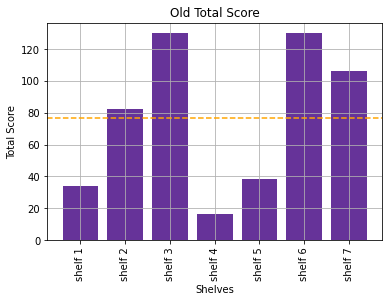

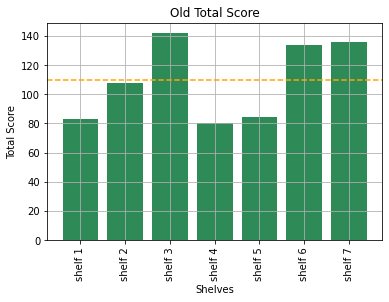

In [84]:
simple_plot(X=shelves_score['Shelf'], y=shelves_score['Total_Score_placed'], 
            title='Old Total Score', X_label='Shelves', y_label='Total Score', kind='bar', color='rebeccapurple', figsize=FIGSIZE)

simple_plot(X=total_score['Shelf'], y=total_score['Final_Score'], 
            title='Old Total Score', X_label='Shelves', y_label='Total Score', kind='bar', color='seagreen', figsize=FIGSIZE)

We can add the shelf assigned into the **one_item_data** that has the placed and unplaced items.

In [85]:
placed_unplaced = one_item_data[one_item_data["Shelf_Item_1"] == "no shelf"]

placed_unplaced["Shelf_Item_1"] = list(unplaced_data["Shelf"])
one_item_data_final = one_item_data.merge(placed_unplaced[["Item_1", "Shelf_Item_1"]], how = "left", on = "Item_1")
one_item_data_final['Shelf'] = one_item_data_final['Shelf_Item_1_y'].combine_first(one_item_data_final['Shelf_Item_1_x'])
one_item_data_final.drop(["Shelf_Item_1_x", "Shelf_Item_1_y"], axis = 1, inplace = True)
one_item_data_final

<ipython-input-85-a4699585402c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Item_1,Frequency,Support,Type_Item_1,Shelf
0,abrasive cleaner,35,0.003559,placed,shelf 4
1,soda,1715,0.174377,placed,shelf 2
2,nut snack,31,0.003152,unplaced,shelf 3
3,chewing gum,207,0.021047,placed,shelf 5
4,butter,545,0.055414,placed,shelf 7
...,...,...,...,...,...
164,condensed milk,101,0.010269,placed,shelf 7
165,organic sausage,22,0.002237,placed,shelf 6
166,canned vegetables,106,0.010778,unplaced,shelf 2
167,chicken,422,0.042908,unplaced,shelf 1


## Comparing Plots

### Support Boxplots

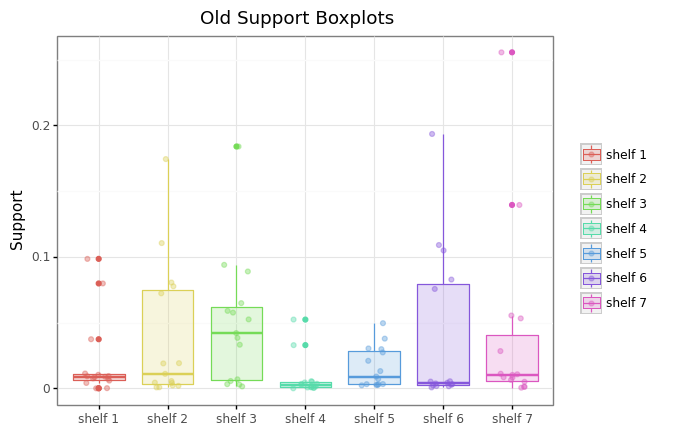

<ggplot: (8768854631774)>

In [86]:
plot_data = one_item_data[one_item_data["Type_Item_1"] == "placed"]

(ggplot(plot_data, aes(x = "Shelf_Item_1", y = "Support", color = "Shelf_Item_1", fill = "Shelf_Item_1"))+
     geom_boxplot(alpha = 0.2)+
     geom_jitter(alpha = 0.4, width = 0.2)+
     labs(title = "Old Support Boxplots",
         x = "",
         y = "Support",
         color = "",
         fill = "")+
     theme_bw()
)

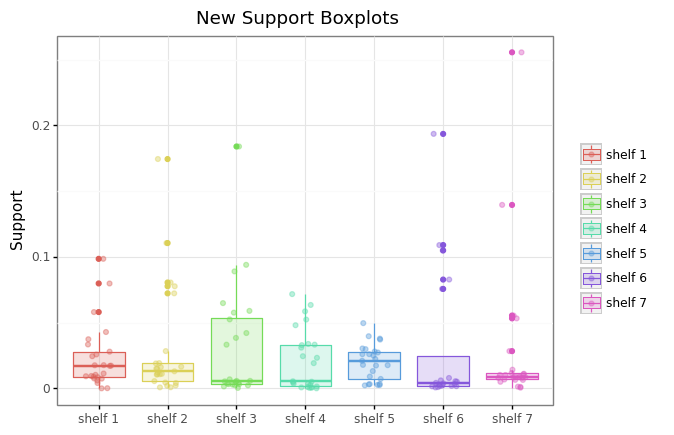

<ggplot: (8768859580880)>

In [87]:
(ggplot(one_item_data_final, aes(x = "Shelf", y = "Support", color = "Shelf", fill = "Shelf"))+
     geom_boxplot(alpha = 0.2)+
     geom_jitter(alpha = 0.4, width = 0.2)+
     labs(title = "New Support Boxplots",
         x = "",
         y = "Support",
         color = "",
         fill = "")+
     theme_bw()
)

### Mean Support Bar Plot

And finally we can compare the mean and median values for the Support in the Shelves with and without the assignation.

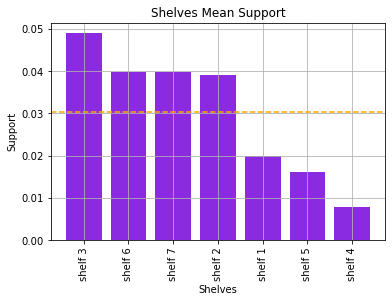

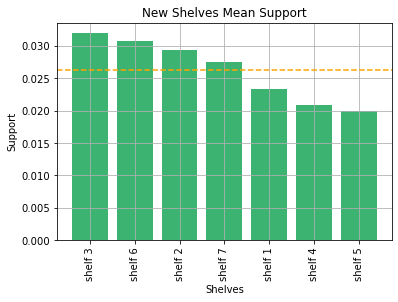

In [88]:
df_plot_mean_final = get_dfplot(kind='mean', target_subset='Shelf', sort_by='Support', item_status=None, ascending=False, final=True)

simple_plot(X=df_plot_mean['Shelf'], y=df_plot_mean['Support'],
            title='Shelves Mean Support', X_label='Shelves', y_label='Support', kind='bar', figsize=FIGSIZE, color = 'blueviolet')

simple_plot(X=df_plot_mean_final['Shelf'], y=df_plot_mean_final['Support'], 
            title='New Shelves Mean Support', X_label='Shelves', y_label='Support', figsize=FIGSIZE, kind='bar', color='mediumseagreen')

### Median Support Bar Plot

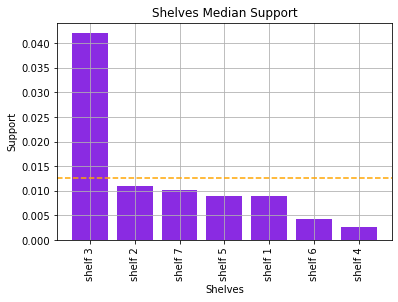

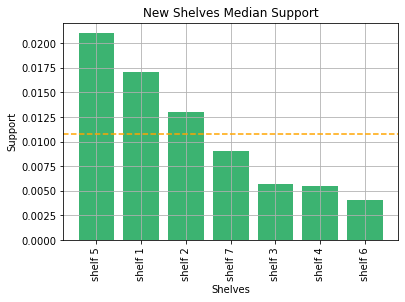

In [89]:
df_plot_median_final = get_dfplot(kind='median', target_subset='Shelf', sort_by='Support', item_status=None, ascending=False, final=True)

simple_plot(X=df_plot_median['Shelf'], y=df_plot_median['Support'],
            title='Shelves Median Support', X_label='Shelves', y_label='Support', kind='bar', figsize=FIGSIZE, color = 'blueviolet')

simple_plot(X=df_plot_median_final['Shelf'], y=df_plot_median_final['Support'], 
            title='New Shelves Median Support', X_label='Shelves', y_label='Support', figsize=FIGSIZE, kind='bar', color='mediumseagreen')

### Scores Bar Plot

#### Support Score

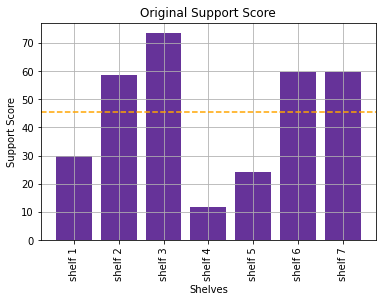

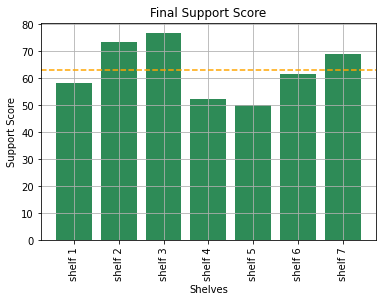

In [90]:
simple_plot(X=shelves_score['Shelf'], y=total_score['Support_Score_placed'], 
            title='Original Support Score', X_label='Shelves', y_label='Support Score', figsize=FIGSIZE, kind='bar', color='rebeccapurple')
simple_plot(X=shelves_score['Shelf'], y=total_score['Support_Score_placed']+total_score['Support_Score_unplaced'], 
            title='Final Support Score', X_label='Shelves', y_label='Support Score', figsize=FIGSIZE, kind='bar', color='seagreen')

#### Leverage Score

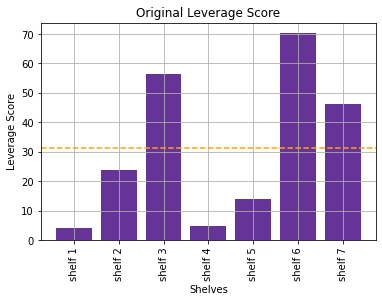

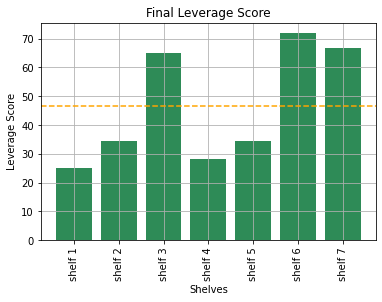

In [91]:
simple_plot(X=shelves_score['Shelf'], y=total_score['Leverage_Score_placed'], 
            title='Original Leverage Score', X_label='Shelves', y_label='Leverage Score', figsize=FIGSIZE, kind='bar', color='rebeccapurple')
simple_plot(X=shelves_score['Shelf'], y=total_score['Leverage_Score_placed']+total_score['Leverage_Score_unplaced'], 
            title='Final Leverage Score', X_label='Shelves', y_label='Leverage Score', figsize=FIGSIZE, kind='bar', color='seagreen')

#### Total Score

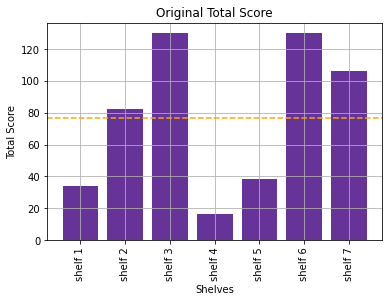

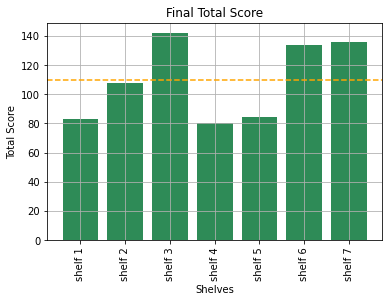

In [92]:
simple_plot(X=shelves_score['Shelf'], y=total_score['Total_Score_placed'], 
            title='Original Total Score', X_label='Shelves', y_label='Total Score', figsize=FIGSIZE, kind='bar', color='rebeccapurple')
simple_plot(X=shelves_score['Shelf'], y=total_score['Final_Score'], 
            title='Final Total Score', X_label='Shelves', y_label='Total Score', figsize=FIGSIZE, kind='bar', color='seagreen')

## Root Mean Total Score 

Root Mean Total Score represents a metric of the balance of the Total Score from the shelves.

$$RMTS = \sqrt{\frac{\sum{TS_{shelfi}-\bar{TS}_{shelfi}}}{7}}$$

In [93]:
print(f'RMTS final score: {RMTS(total_score["Final_Score"])}')

RMTS final score: 25.34698142933122


Finally we get all the sorted results into a pandas datafrane

In [94]:
def get_final_results(printf):
    d = {}
    for shelf in shelf_name:
        l = []
        if printf:
            print('\n\n')
            print(shelf)
            print('-' * 50)
        for i in range(one_item_data_final.shape[0]):
            if one_item_data_final["Shelf"][i] == shelf:
                data_res = one_item_data_final["Item_1"][i]
                l.append(data_res)
                if printf:
                    print(data_res)
        d[shelf] = l
    return d

In [95]:
d_final_res = get_final_results(printf=True)




shelf 1
--------------------------------------------------
rice
soft cheese
instant coffee
flower (seeds)
light bulbs
photo/film
butter milk
pet care
candles
newspapers
preservation products
coffee
sliced cheese
meat
sound storage medium
dishes
kitchen towels
long life bakery product
baking powder
dog food
UHT-milk
cling film/bags
potted plants
shopping bags
chicken



shelf 2
--------------------------------------------------
soda
white wine
misc. beverages
packaged fruit/vegetables
canned beer
liquor
red/blush wine
prosecco
dish cleaner
liqueur
bottled beer
bottled water
processed cheese
rum
pasta
brandy
fruit/vegetable juice
mustard
herbs
sparkling wine
cocoa drinks
salt
canned fish
whisky
canned vegetables



shelf 3
--------------------------------------------------
nut snack
white bread
dental care
rolls/buns
fish
tidbits
bags
pastry
syrup
pork
honey
brown bread
waffles
frankfurter
beef
sausage
zwieback
specialty fat
liver loaf
hamburger meat
cereals
meat spreads
jam
soap



s

In [96]:
# As dataframe
df_final_res = pd.DataFrame.from_dict(d_final_res, orient='index')

# Transpose
df_final_res = df_final_res.T
df_final_res.reset_index(drop=True, inplace=True)

# to csv
#df_final_res.to_csv('W02_final.csv', sep=',', encoding='utf-8', index=False)

# display
df_final_res

,shelf 1,shelf 2,shelf 3,shelf 4,shelf 5,shelf 6,shelf 7
0,rice,soda,nut snack,abrasive cleaner,chewing gum,specialty vegetables,butter
1,soft cheese,white wine,white bread,male cosmetics,grapes,citrus fruit,spread cheese
2,instant coffee,misc. beverages,dental care,toilet cleaner,dessert,tropical fruit,yogurt
3,flower (seeds),packaged fruit/vegetables,rolls/buns,baby food,cream cheese,tea,specialty cheese
4,light bulbs,canned beer,fish,cat food,pickled vegetables,spices,roll products
5,photo/film,liquor,tidbits,hair spray,popcorn,rubbing alcohol,whole milk
6,butter milk,red/blush wine,bags,bathroom cleaner,ice cream,root vegetables,cream
7,pet care,prosecco,pastry,frozen vegetables,pudding powder,flower soil/fertilizer,curd cheese
8,candles,dish cleaner,syrup,napkins,cooking chocolate,female sanitary products,soups
9,newspapers,liqueur,pork,sugar,chocolate marshmallow,ready soups,Instant food products


# Conclusions

The method used, by scoring the shelves with the placed items and calculating the score for each unplaced items resulted in a more balanced shelves in terms of support value, meaning shelves 1,4 and 5 will be more visited than without the unplaced items.

The algorithm obtains the best solution among 2187 different set of weights and combination of unplaced items assigned. The mean support we've got with this assignment is a minimum value and most clients will visit every shelf in the store.

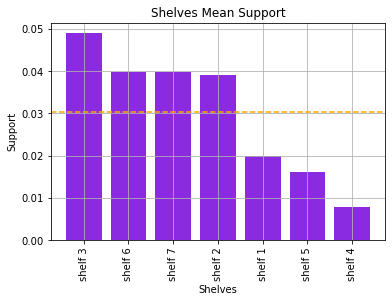

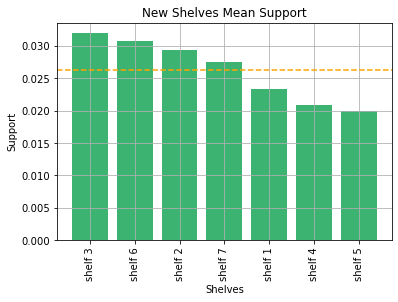

In [97]:
df_plot_mean_final = get_dfplot(kind='mean', target_subset='Shelf', sort_by='Support', item_status=None, ascending=False, final=True)

simple_plot(X=df_plot_mean['Shelf'], y=df_plot_mean['Support'],
            title='Shelves Mean Support', X_label='Shelves', y_label='Support', kind='bar', figsize=FIGSIZE, color = 'blueviolet')

simple_plot(X=df_plot_mean_final['Shelf'], y=df_plot_mean_final['Support'], 
            title='New Shelves Mean Support', X_label='Shelves', y_label='Support', figsize=FIGSIZE, kind='bar', color='mediumseagreen')